# Exponential Smoothing


* Time Series data is generally unique because of the relationship between current data and past data
* Most forecasting methods use this relationship to predict future data.
* Exponential Smoothing is a prediction method that makes an assumption that a future observation is the weighted sum of past observations.
* It's a univariate method, meaning it only uses a single variable: The time series itself
* It also makes the assumption that this weight decreases exponentially over time.
* There are three types of Exponential Smoothing:
    - Simple Exponential Smoothing
    - Double Exponential Smoothing (Holt's Linear Method)
    - Triple Exponential Smoothing (Holt Winters)

## Simple Exponential Smoothing (SES)

* Simple exponential Smoothing, as the name suggests is the simplest form
* It assumes no trend or seasonality
* The formula is as follows:
    

$level_{t} = \alpha y_{t} + (1-\alpha)level_{t-1}$

$level_{0} = y_{0}$

* We won't delve into the formula here, but the parameter we need to be aware of is the $\alpha$ (alpha) value.
* The alpha value is something called a hyperparameter. This differs from a model parameter in that it cannot be learned or estimated from the data alone.
    - An example model parameter might be the distribution of the data.
    - In this example, looking at the data alone will not tell us the optimal hyperparameter (alpha) to use.
* For SES, alpha controls the strength of the exponential decay.
* It always falls between 0 and 1
* A large alpha value places more weight on more recent observations
* A smaller alpha value allows more distant observations to still have an impact on the forecast.
* The good news is that statsmodels can estimate an alpha for us by minimising the error (the difference between the prediction and the actual)

In [1]:
import pandas as pd
from matplotlib.dates import AutoDateLocator

# Importing and setting up the DataFrame
dji = pd.read_csv("dji.csv", parse_dates=['Date'])
dji = dji.sort_values(by="Date", ascending=True).set_index("Date")

# Creating a subset of the data
dji_summer = dji["2014-05":"2014-07"].copy()

# Visualising the data
ax = dji_summer["DJI.Close"].plot()
ax.xaxis.set_major_locator(AutoDateLocator(interval_multiples=False))
ax;

* Note that the AutoDateLocator from matplot ensures that the date is well displayed
* We can now fit a SES model using statsmodels

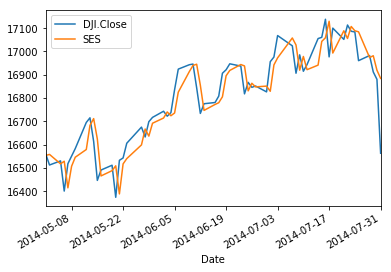

In [2]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses = SimpleExpSmoothing(dji_summer["DJI.Close"].values)              # Creating an instance of an SES model & supplying data
ses_model = ses.fit()                                                 # Fitting the data to the model
dji_summer["SES"] = ses_model.fittedvalues                            # Creating a new variable to compare
ax = dji_summer[["DJI.Close", "SES"]].plot()                          # Plotting the data
ax.xaxis.set_major_locator(AutoDateLocator(interval_multiples=False)) # Correcting the date on the axis

* Our model will find the optimal alpha value for us as part of the fitting process.
* If we want to evaluate the alpha, we can get the value as follows:

In [3]:
ses_model.params['smoothing_level']

0.8922003343920327

* Here the alpha value is quite large which means more weight has been placed on more recent observations
* If we want to supply our own alpha value we can do so as follows:

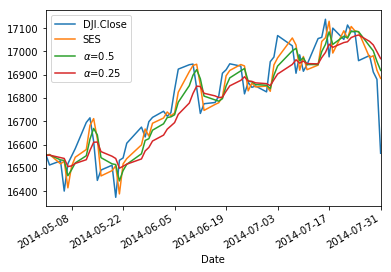

In [4]:
# Since we've already supplied our model with data we can set the initial level (value of the first observation)
initial_level = ses_model.params['initial_level']

# Setting the alpha to 0.5
dji_summer[r'$\alpha$=0.5'] = ses.predict(params={'smoothing_level':0.5, 'initial_level': initial_level}, start=0)

# Setting the alpha to 0.25
dji_summer[r'$\alpha$=0.25'] = ses.predict(params={'smoothing_level':0.25, 'initial_level': initial_level}, start=0)

# PLotting our data
ax = dji_summer[["DJI.Close", "SES", r'$\alpha$=0.5', r'$\alpha$=0.25']].plot()

# Making the chart look nice
ax.xaxis.set_major_locator(AutoDateLocator(interval_multiples=False))

* SES is simple to understand, yet limited.
* It will only generate a single value for a forecast which isn't a great deal of use if you want to make a forecast

In [5]:
# Making a forecast
num_observations = len(dji_summer)
ses_model.predict(start=num_observations, end=num_observations + 10)

array([16597.93567066, 16597.93567066, 16597.93567066, 16597.93567066,
       16597.93567066, 16597.93567066, 16597.93567066, 16597.93567066,
       16597.93567066, 16597.93567066, 16597.93567066])

## Double Exponential Smoothing (DES)

* Double Exponential Smoothing (DES) (also called Holt's Linear Method) is similar to SES with the addition of a trend component.
* This trend component will also exponentially decay and as a result the impact of the trend componenet will vary over time according to the strength of the recent trend.
* The formula is as follows:


𝑓𝑜𝑟𝑒𝑐𝑎𝑠𝑡𝑡+ℎ=𝑙𝑒𝑣𝑒𝑙𝑡+ℎ∗𝑡𝑟𝑒𝑛𝑑𝑡   
𝑙𝑒𝑣𝑒𝑙𝑡=𝛼𝑦𝑡+(1−𝛼)(𝑙𝑒𝑣𝑒𝑙𝑡−1+𝑡𝑟𝑒𝑛𝑑𝑡−1)   
𝑡𝑟𝑒𝑛𝑑𝑡=𝛽(𝑙𝑒𝑣𝑒𝑙𝑡−𝑙𝑒𝑣𝑒𝑙𝑡−1)+(1−𝛽)𝑡𝑟𝑒𝑛𝑑𝑡−1   

* Again we're not going to focus on this, and instead tell you what you need to know.
* You'll see the $ \alpha $ (alpha) hyperparameter again, This means exactly the same thing as in SES: It controls the strength of the overall exponential decay
* We also have a $ \beta $ (beta) hyperparameter which is referred to as the trend smoothing factor. This essentially controls the change in trend.
* Let's explore this with an example:

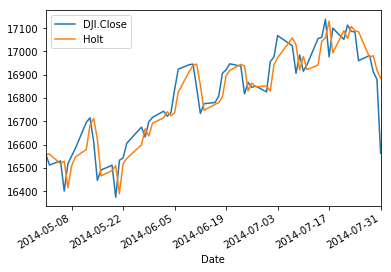

In [6]:
from statsmodels.tsa.holtwinters import Holt

# Creating an instance of the model and supplying some data
holt = Holt(dji_summer["DJI.Close"].values, exponential=True)

# Fitting the model
holt_model = holt.fit()

# Creating a new variable based upon the fitted model
dji_summer["Holt"] = holt_model.fittedvalues

# Creating a chart
ax = dji_summer[["DJI.Close", "Holt"]].plot()
ax.xaxis.set_major_locator(AutoDateLocator(interval_multiples=False))

* As previously, our model will determine the optimal hyperparameter values for us
* We can return the alpha and beta as follows:

In [7]:
(holt_model.params['smoothing_level'], holt_model.params['smoothing_slope'])

(0.8922561812124674, 0.0)

* Here we have a 0 value for beta. This means that the inital trend has not changed over the course of the time series data.
* This makes sense when looking at the above plot.
* It also means that our DES is the same as the SES we created earlier.
* There is a sharp downward trend right at the end of the time series, however this likely won't have had an impact due to it's recency
* However the SDS model allows us to make a prediction as follows:

In [8]:
num_observations = len(dji_summer)
predictions = holt_model.predict(start=num_observations, end=num_observations + 10)
predictions

array([16598.40698937, 16598.84297481, 16599.27897169, 16599.71498003,
       16600.15099983, 16600.58703107, 16601.02307377, 16601.45912792,
       16601.89519353, 16602.33127059, 16602.7673591 ])

* We can look at the change in predictions using the diff function we met previously:

In [9]:
pd.Series(predictions).diff().values

array([       nan, 0.43598544, 0.43599689, 0.43600834, 0.43601979,
       0.43603124, 0.4360427 , 0.43605415, 0.43606561, 0.43607706,
       0.43608851])

* DN: Why are these changing if beta isn't?

## Triple Exponential Smoothing (Holt-Winters)

* As we've seen, time series can also have a seasonal component
* If we add seasonality into our Double Exponential Smoothing (DES) we end up with Triple Exponential Smoothing, also called Holt-Winters
* We will need to specify a seasonal component, and specify the periodicity of this
* The formula for Holt-Winters is as follows:

$forecast_{t+h} = level_{t} + h*trend_{t} + seasonal_{t+h-m(k+1)}$

$level_{t} = \alpha (y_{t}-seasonal_{t-m}) + (1-\alpha)(level_{t-1} + trend_{t-1})$

$trend_{t} = \beta(level_{t}-level_{t-1}) + (1-\beta)trend_{t-1}$

$seasonal_{t} = \gamma (y_{t}-level_{t-1}-trend_{t-1}) + (1-\gamma)seasonal_{t-m}$

* The periodicity of the seasonal component is captured by $m$ and its inclusion (together with $k$) into the indices ensures that only seasonal values of the same period are used together.
* For example, if the periodicity is weekly then the seasonal value for next Monday is calculated by looking at the seasonal values for previous Mondays.
* Second, the *level* is now calculated by first subtracting the seasonal value (from a full cycle ago) from the observed value.
* Finally, the seasonal value is updated by multiplying $\gamma$ with the current seasonal value (observed minus level and trend) and $(1-\gamma)$ with the previous seasonal value.
* This is quite complicated so don't worry if you don't get all this first time!

* To fit Holt-Winters' exponential smoothing we can use `ExponentialSmoothing` from the **statsmodels** package.

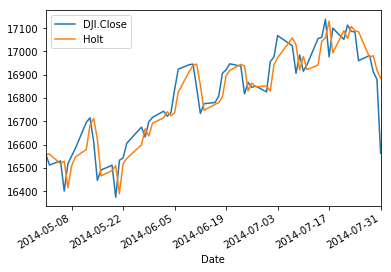

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# we will come back to what the value "add" means in the next section
# our seasonal periods will be 5 (number of working days in a week)

hw = ExponentialSmoothing(
    dji_summer["DJI.Close"].values,
    trend="add",
    seasonal="add",
    seasonal_periods=5
)

hw_model = hw.fit()
dji_summer["HoltWinters"] = hw_model.fittedvalues
from statsmodels.tsa.holtwinters import Holt

# Creating an instance of the model and supplying some data
holt = Holt(dji_summer["DJI.Close"].values, exponential=True)

# Fitting the model
holt_model = holt.fit()

# Creating a new variable based upon the fitted model
dji_summer["Holt"] = holt_model.fittedvalues

# Creating a chart
ax = dji_summer[["DJI.Close", "Holt"]].plot()
ax.xaxis.set_major_locator(AutoDateLocator(interval_multiples=False))

* We can return the values for alpha, beta and gamma (seasonal value) as follows:

In [11]:
(hw_model.params['smoothing_level'], hw_model.params['smoothing_slope'], 
 hw_model.params['smoothing_seasonal'])

(0.894736839708109, 0.04968950918756429, 0.10526315549758278)

* We've made an assumption that the seasonality is 5 days, which seems reasonable given that stocks are traded during the week.
* Note that now we've included seasonality, we have a value for beta (trend component)
* We can generate some predictions as follows:

In [12]:
hw_model.predict(start=num_observations, end=num_observations + 10)

array([16595.19353256, 16595.13030782, 16566.04345607, 16575.04157568,
       16522.56614866, 16525.31220633, 16525.24898159, 16496.16212984,
       16505.16024945, 16452.68482242, 16455.4308801 ])

## Exercise

1. Apply all three algorithms to the *Close* column from the `barclays.csv` data with suitable parameter values.
2. Create a plot with the fitted values from the three models and the original data
3. Add forecasts from the three models to the same plot

In [13]:
# Create and set the DataFrame

barclays = pd.read_csv('barclays.csv')
barclays['Date'] = pd.to_datetime(barclays['Date'])
barclays.set_index('Date',inplace=True)

#### SES

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Create an instance of the model & set the data
ses = SimpleExpSmoothing(barclays["Close"].values)                    # Creating an instance of an SES model & supplying data

# Fit the Model and Create a Variable
ses_model = ses.fit()                                                 # Fitting the data to the model
barclays["SES"] = ses_model.fittedvalues                              # Creating a new variable to compare

#### DES (Holt)

In [15]:
from statsmodels.tsa.holtwinters import Holt

# Creating an instance of the model and supplying some data
holt = Holt(barclays["Close"].values, exponential=True)

# Fitting the model
holt_model = holt.fit()

# Creating a new variable based upon the fitted model
barclays["Holt"] = holt_model.fittedvalues

#### TES (Holt-Winters)

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create an instance of the model and set data / arguments
hw = ExponentialSmoothing(
    barclays['Close'].values,
    trend='add',
    seasonal='add',
    seasonal_periods=5
)

# Fit the model & Create a Variable
hw_model = hw.fit()
barclays['HoltWinters'] = hw_model.fittedvalues

#### Plot

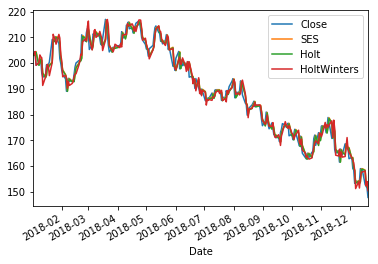

In [17]:
# Creating a chart
ax = barclays[["Close", "SES", "Holt", "HoltWinters"]].plot()
ax.xaxis.set_major_locator(AutoDateLocator(interval_multiples=False))

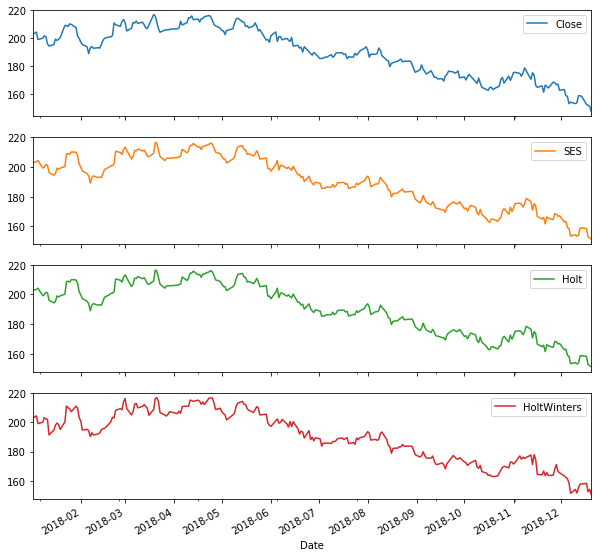

In [18]:
# Subplots
ax = barclays[["Close", "SES", "Holt", "HoltWinters"]].plot(figsize=(10,10), subplots=True)

## Dampening

* Holt Winters forecasts won't increase (or decrease) continually, which is realistic
* However, the components upon which they're based (level, trend, seasonal) won't change
* This isn't realistic for real life scenarios.
* For example, it's unlikely that the Dow Jones will increase forever without some form of downturn
* Similarly Barclay's share price won't continue to drop forever (hopefully for Barclays!)
* For this reason, we introduce dampening.
* This is basically a way to decrease the effect of the trend on the time series
* We can apply Dampening to Holt (DES) and Holt-Winters (TES) models
* We can do this with an extra parameter $\phi$ (phi, pronounced fee)

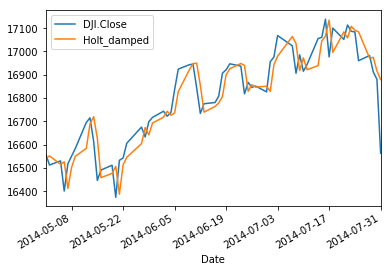

In [19]:
# Instance the model & supply the data

holt_damped = Holt(
    dji_summer["DJI.Close"].values,
    exponential=True,
    damped=True
)

# Ft the model and create a new variable
holt_damped_model = holt_damped.fit()
dji_summer["Holt_damped"] = holt_damped_model.fittedvalues

# PLot the model
ax = dji_summer[["DJI.Close", "Holt_damped"]].plot()
ax.xaxis.set_major_locator(AutoDateLocator(interval_multiples=False))

* We can get the alpha, beta and phi values as follows:

In [20]:
(holt_damped_model.params['smoothing_level'], holt_damped_model.params['smoothing_slope'],
holt_damped_model.params['damping_slope'])

(0.7372791581264476, 0.7372791565751314, 0.31759732826678067)

* And make a prediction as follows:

In [21]:
holt_damped_model.predict(start=num_observations, end=num_observations + 10)

array([16589.21802981, 16571.09167992, 16565.3389447 , 16563.51230925,
       16562.93221686, 16562.74798532, 16562.6894743 , 16562.6708914 ,
       16562.66498953, 16562.66311511, 16562.6625198 ])

* The introduction of dampening has resulted in a non-zero value for beta.
* The value for phi is quite small which means the dampening effect is strong. 
* We can see that in the forecasted values as they quickly become almost constant after only four steps ahead. 
* At the end of this chapter will we see if this model is more accurate than a model without dampening.

## Additive vs multiplicative seasonality

* Thus far in our Holt-Winters (TES) model we've assumed that the seasonality is 'additive'
* If you cast your mind back to the previous exercises, we had some parameters that we specified as 'add'. Here, we were defining that our models were additive.
* Additive means that we assume that seasonality is constant throughout the time series
* Don't confuse this with the gamma parameter which causes the influence of seasonaliy to change
* For a weekly seasonal component, an additive model will add or subtract a constant amount
* This amount will only vary depending upon what day of the week it is
* For a multiplicative the seasonal component will depend upon what day of the week it is and the value of the time series

The formulation of Holt-Winters multiplicative model is different from the additive model and we add it here for completeness.

$forecast_{t+h} = (level_{t} + h*trend_{t})*seasonal_{t+h-m(k+1)}$

$level_{t} = \alpha \frac{y_{t}}{seasonal_{t-m}} + (1 - \alpha)(level_{t-1} + trend_{t-1})$

$trend_{t} = \beta^*(level_{t}-level_{t-1}) + (1 - \beta^*)trend_{t-1}$

$seasonal_{t} = \gamma \frac{y_{t}}{(level_{t-1} + trend_{t-1})} + (1 - \gamma)seasonal_{t-m}$

* We can apply the multiplicative model by using the same `ExponentialSmoothing` class from **statsmodels**.
* The implementation of Holt-Winters in **statsmodels** also allows you to specify if the trend is additive or multiplicative by setting the `trend` argument to either "add" or "mul". 

## Exercise

1. Apply HoltWinters (TES) to the *Close* column from the `barclays.csv` dataset with:  
    a. dampening on/off  
    b. multiplicative/additive trend  
    c. multiplicative/additive seasonality  
    
2. Don't bother with: Add the above models to a plot with the original data. Based on the visualisations which model is the best fit?

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

barclays = pd.read_csv('barclays.csv')

param_list = [
    dict(trend='add', seasonal='add', damped=False),
    dict(trend='mul', seasonal='add', damped=False),
#     dict(trend='add', seasonal='mul', damped=False),
#     dict(trend='mul', seasonal='mul', damped=False),
    dict(trend='add', seasonal='add', damped=True),
    dict(trend='mul', seasonal='add', damped=True),
#     dict(trend='add', seasonal='mul', damped=True),
#     dict(trend='mul', seasonal='mul', damped=True)
]

for i, value in enumerate(param_list):
    
    print('Iteration: {}'.format(i))
    
    trend = value['trend']
    seasonal = value['seasonal']
    damped = value['damped']

    # Create an instance of the model and set data / arguments
    hw = ExponentialSmoothing(
        barclays['Close'].values,
        trend=trend,
        seasonal=seasonal,
        damped=damped,
        seasonal_periods=5
    )

    # Fit the model & Create a Variable
    hw_model = hw.fit()
    barclays['HW_{}'.format(i)] = hw_model.fittedvalues

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [36]:
# Limit the columns to the relevent ones we're interested in

columns = [col for col in barclays.columns if 'HW_' in col]
columns.append('Close')
df_predictions = barclays[columns]

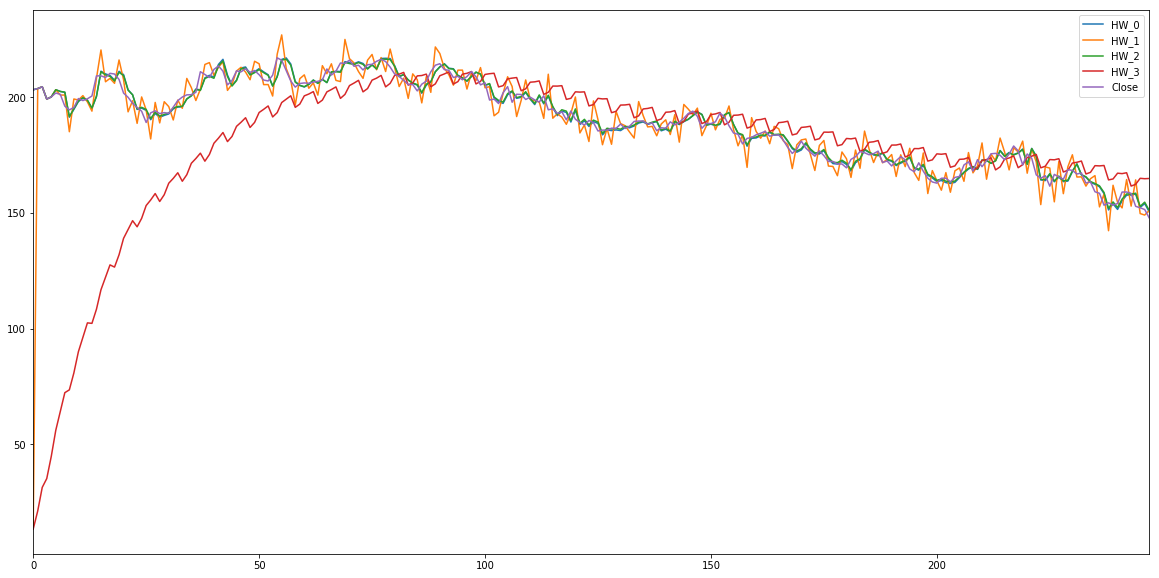

In [39]:
df_predictions.plot(figsize=(20,10));

## Comparing Models

* Comparing models using visualisations isn't an objective measure
* Instead we can use an objective metric such as the sum of squared errors (SSE)

In [31]:
(ses_model.sse, holt_model.sse, holt_damped_model.sse, hw_model.sse)

(1800.3021581457365, 1787.0627740898478, 454214.9179883455, 1749.4044851919061)

Exercise apply ses to your Barclays Models